In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import date

In [2]:
df=pd.read_csv('portal-offers-05.06.2020.csv')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
geo=pd.read_csv('population.csv')

In [53]:
df2=df[(df.main_type_name == 'mieszkanie') & (df.transaction_name == 'sprzedaż')]
#df.loc[[df['main_type_name']=='dom' or df['main_type_name']== 'mieszkanie']]

In [54]:
df2.drop(columns=['portal_id','main_type_id','main_type_name','transaction','transaction_name','id','description','location_district_name','raw_data','location_province_name','building_floornumber','portal_name','add_date','update_date','last_scan_date','source_add_date','source_update_date','location_precinct_name','location_street_name'],inplace=True)

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [55]:
df2['location_latitude'] = pd.to_numeric(df2.location_latitude, errors='coerce')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
df2['location_longitude'] = pd.to_numeric(df2.location_longitude, errors='coerce')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
df2[['location_latitude','location_longitude']] = df2[['location_latitude','location_longitude']].replace(',','.')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [58]:
df3=df2[(df2['location_latitude'].notnull()) & (df2['location_longitude'].notnull())]

In [59]:
var_house=df3[['price', 'area_total', 'price_permeter']].apply(pd.to_numeric, errors='coerce')

In [60]:
df5=df3.merge(var_house, left_index=True, right_index=True)

In [61]:
df6=df5.drop(columns=['price_x','area_total_x','price_permeter_x'])

In [62]:
df6.area_total_y=np.where(df6.area_total_y.isnull(),df6.price_y/df6.price_permeter_y,df6.area_total_y)

In [63]:
df6.price_permeter_y=np.where(df6.price_permeter_y.isnull(),df6.price_y/df6.area_total_y,df6.price_permeter_y)

In [64]:
#jeżeli brak piętra to założenie że na parterze, bądź parterowy dom
df6.apartment_floor.fillna(0,inplace=True)
#jeżeli 'apartment_room' to liczba pokoi a nie wszystkich pomieszczeń
df6.apartment_room_number.fillna(1,inplace=True)

In [65]:
convert_dict = {'apartment_room_number': int,
                'apartment_floor': int
               } 

In [66]:
df7=df6.astype(convert_dict)

In [67]:
ilo=df7.building_year.isnull().sum()/df7.building_year.sum()
ilo
#stanowi to 0.5% więc można usunąc te wyniki bądź spróbować znaleźć, poprzez kmean albo inny model jaki powinen być wiek budynku
#na ten moment ja wyrzucam
df8 = df7[df7.building_year.notnull()]
# analiza tylko tych obiektów, które posiadają cene
df9 = df8[df8.price_y.notnull()]

In [70]:
def rm_out(df,columns=None):
    if columns:
        columns = columns
    else:
        columns = df.columns
        
    df_out = df.copy()
    for c in columns:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        IRQ = q3 - q1
        df_out = df_out.loc[ (df[c] <= q3 + 1.5 * IRQ) & (df[c] >= q1 - 1.5 * IRQ) ]
        
    df_out.index = range(len(df_out))
    return df_out

In [71]:
col=['price_y','apartment_floor','area_total_y']
df_clean=rm_out(data,col)

In [100]:
miasta=pd.DataFrame(df_clean.location_city_name.str.capitalize())

In [110]:
merget_df=df_clean.merge(miasta, left_index=True,right_index=True)
merget_df.drop(['location_city_name_x'], axis=1,inplace=True)
merget_df.rename(columns={'location_city_name_y':'location_city_name','price_y':'price','area_total_y':'area_total'}, inplace=True)

In [114]:
dane_all=merget_df.merge(geo,left_on='location_city_name',right_on='Miasto',how='inner')

In [131]:
dane_all.Populacja = [n.replace(' ','') for n in dane_all.Populacja]

In [142]:
populacja=pd.DataFrame(dane_all.Populacja.astype(int))
dane_sum=dane_all.merge(populacja,left_index=True,right_index=True)
dane_sum.drop(columns=['Populacja_x'],axis=1, inplace=True)

In [119]:
# rozmiar_miast={'Warszawa':'najwieksze_miasta','Krakow':'najwieksze_miasta','Łódź':'najwieksze_miasta','Wrocław':'najwieksze_miasta','Poznań':'najwieksze_miasta',
#                'Gdańsk':'wieksze_miasta','Szczecin':'wieksze_miasta','Bydgoszcz':'wieksze_miasta','Lublin':'wieksze_miasta','Białystok':'wieksze_miasta','Katowice':'wieksze_miasta',
#                'Gdynia':'duze_miasta','Częstochowa':'duze_miasta','Radom':'duze_miasta','Toruń':'duze_miasta','Sosnowiec':'duze_miasta','Kielce':'duze_miasta','Rzeszów':'duze_miasta','Gliwice':'duze_miasta','Zabrze':'duze_miasta',
#                 'Olsztyn':'duze_miasta','Bielsko-Biała':'duze_miasta','Bytom':'duze_miasta','Zielona Góra':'duze_miasta','Rybnik':'duze_miasta','Ruda Śląska':'duze_miasta','Opole':'duze_miasta','Tychy':'duze_miasta','Gorzów Wielkopolski':'duze_miasta',
#                 'Płock':'duze_miasta','Dąbrowa Górnicza':'duze_miasta','Elbląg':'duze_miasta','Wałbrzych':'duze_miasta','Włocławek':'duze_miasta', 'Tarnów':'duze_miasta','Chorzów':'duze_miasta', 'Koszalin':'duze_miasta','Kalisz':'duze_miasta'}
# #pozostałe to będą małe_miasta
        

In [147]:
city_size=[]

for num in dane_sum['Populacja_y']:
    if num >=500000:
        city_size.append('najwieksze_miasta')
    elif num <500000 and num >=250000:
        city_size.append('wieksze_miasta')
    elif num <250000 and num >=100000:
        city_size.append('duze_miasta')
    elif num <100000 and num >=50000:
        city_size.append('srednie_miasta')
    elif num <50000 and num >=25000:
        city_size.append('wieksze_miasta')
    else:
        city_size.append('pozostale')

dane_sum['city_size']=city_size

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24864 entries, 0 to 24866
Data columns (total 23 columns):
apartment_room_number          24864 non-null int64
apartment_floor                24864 non-null int64
building_year                  24864 non-null float64
location_latitude              24864 non-null float64
location_longitude             24864 non-null float64
private_offer                  24864 non-null int64
price                          24864 non-null float64
area_total                     24864 non-null float64
location_city_name             24864 non-null object
Unnamed: 0                     24864 non-null int64
index                          24864 non-null int64
Miasto                         24864 non-null object
Kobiety                        24864 non-null object
Mężczyźni                      24864 non-null object
Powiat                         24864 non-null object
Województwo                    24864 non-null object
Współrzędne Geograficzne       24864 non-nu

In [154]:
#zmiana zmiennych kategotycznych na liczbowe
data=pd.get_dummies(dane_sum,columns=['city_size'])
data.dropna(inplace=True)

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [76]:
# recent_date = data['apartment_floor'].max()
# data[data['apartment_floor'] == recent_date]

In [77]:
#standaryzacja danych

In [78]:
scalar = MinMaxScaler().fit(df_clean)
standard=scalar.transform(df_clean)
#taki uklad może być jak robimy fit. na całym zbiorze danych


ValueError: could not convert string to float: 'pruszcz gdański'

In [90]:
from sklearn.model_selection import train_test_split

In [ ]:
X=df_clean.drop(['price_y'],axis=1)
Y=df_clean['price_y'].values

In [ ]:
train_x, test_x, train_y, test_y  = train_test_split(X,Y, test_size =0.2, random_state=123)

In [45]:
#sprawdzenie istotności zmiennych na model, metodą bootsrapingu
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective="reg:squarederror", 
                          seed=123, booster="gbtree")
xg_reg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

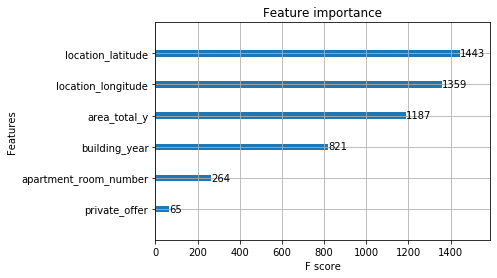

In [46]:
xgb.plot_importance(xg_reg,max_num_features = 10)

na podstawie powyższego wzięto do analizy tylko 10 pierwszych rekordów

In [166]:
# dane pod modele

**regresja wielomianowa**

In [122]:
from sklearn.metrics import r2_score

In [64]:
from statsmodels.formula.api import ols

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49524 entries, 82 to 423636
Data columns (total 8 columns):
apartment_room_number    49524 non-null int64
apartment_floor          49524 non-null int64
building_year            49524 non-null float64
location_latitude        49524 non-null float64
location_longitude       49524 non-null float64
private_offer            49524 non-null int64
price_y                  49524 non-null float64
area_total_y             49524 non-null float64
dtypes: float64(5), int64(3)
memory usage: 4.7 MB


In [119]:
mul_lin_regress = ols('price_y ~  apartment_room_number + location_latitude * location_longitude + building_year + apartment_floor+ area_total_y', data).fit()
print(mul_lin_regress.summary().tables[1])

                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             2.454e+05   1.41e+04     17.440      0.000    2.18e+05    2.73e+05
apartment_room_number                 1.427e+05   1617.816     88.179      0.000    1.39e+05    1.46e+05
location_latitude                    -2091.8872    120.545    -17.354      0.000   -2328.156   -1855.618
location_longitude                   -1748.1085     65.775    -26.577      0.000   -1877.028   -1619.189
location_latitude:location_longitude     5.5162      0.367     15.019      0.000       4.796       6.236
building_year                           -6.3799      5.885     -1.084      0.278     -17.914       5.154
apartment_floor                       5433.0374   1771.334      3.067      0.002    1961.202    8904.872
area_total_y                             0.4926      0.

In [124]:
y_ = mul_lin_regress.predict(data)
print("R^2 statistic:           ", r2_score(Y, y_))
print("Residual Standard Error: ", np.std((Y, y_), ddof=2))

R^2 statistic:            0.16659202759046865
Residual Standard Error:  282156.3114004949


In [106]:
print(mul_lin_regress.summary())

                            OLS Regression Results                            
Dep. Variable:                price_y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     1605.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:08:56   Log-Likelihood:            -7.0076e+05
No. Observations:               49524   AIC:                         1.402e+06
Df Residuals:                   49517   BIC:                         1.402e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.637e+

rozpatrujemy dalej dopasowanie zmiennych, ponieważ prob (F-statistic) jest < 0.05 więc oznacza, że model jako " całość " ma przynajmniej 1den feature, który jest istotny

In [66]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

In [114]:
x_train.columns

Index(['apartment_room_number', 'apartment_floor', 'building_year',
       'location_latitude', 'location_longitude', 'private_offer',
       'area_total_y'],
      dtype='object')

In [68]:
model = LinearRegression()
rfe = RFECV(model)
rfe = rfe.fit(x_train, y_train)

print(rfe.support_) #czy dana zmienna jest istotna
print(rfe.ranking_) 

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[ True  True False  True  True  True  True]
[1 1 2 1 1 1 1]


In [100]:
key=X.columns
rank=rfe.ranking_

In [79]:
ranking=dict(zip(key, rank))

{'apartment_room_number': 1,
 'apartment_floor': 1,
 'building_year': 2,
 'location_latitude': 1,
 'location_longitude': 1,
 'private_offer': 1,
 'area_total_y': 1}

In [95]:
new_list = {k: v for k,v in ranking.items() if v[1] < 2}

TypeError: 'set' object is not subscriptable

In [116]:
mul_lin_regress2 = ols("price_y ~  apartment_room_number + location_latitude * location_longitude + apartment_floor", data).fit()
print(mul_lin_regress2.summary())

                            OLS Regression Results                            
Dep. Variable:                price_y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     1979.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:31:30   Log-Likelihood:            -7.0064e+05
No. Observations:               49524   AIC:                         1.401e+06
Df Residuals:                   49518   BIC:                         1.401e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [125]:
pred = mul_lin_regress2.predict(data)
print("R^2 statistic:           ", r2_score(Y, pred))
print("Residual Standard Error: ", np.std((Y, pred), ddof=2))

R^2 statistic:            0.16656564179659095
Residual Standard Error:  282153.1204990543


żadne z uproszczeń nie pozwoliło na zwiększenie dokładności modelu

In [175]:
# testowanie modelu

In [80]:
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression,LinearRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import sklearn

In [88]:
x=data[['area_total_y','apartment_room_number','location_latitude','location_longitude','building_year','apartment_floor','private_offer']]
y=data[['price_y']]

In [91]:
scale1 = preprocessing.MinMaxScaler().fit(x)
x_norm = scale1.transform(x)

scale2 = preprocessing.MinMaxScaler().fit(y)
y_norm = scale2.transform(y)

train_x, test_x, train_y, test_y  = train_test_split(x_norm,y_norm, test_size =0.2, random_state=123)

**drzewo decyzyjne**

In [92]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

In [93]:
regressor = DecisionTreeRegressor()
[train_data, test_data, 
 train_target, test_target] = train_test_split(
    x_norm, y_norm)
regressor.fit(train_data, train_target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

AttributeError: 'DecisionTreeRegressor' object has no attribute 'tree_'

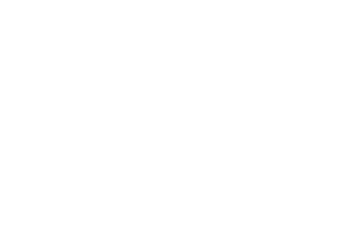

In [99]:
_ = sklearn.tree.plot_tree(regressor)

In [94]:
splitter=['best', 'random']
max_depth=[2,10,1]

In [96]:
best_variables=pd.DataFrame()
for i in max_depth:
    for s in splitter:
        regressor = DecisionTreeRegressor(max_depth=i,splitter=s,random_state=123)

        cv_results = cross_validate(regressor, x_norm, y, cv=10)
        sorted(cv_results)
        
        best_variables1=pd.DataFrame({'głębokość drzewa': [i],
                                     'strategia': [s],
                                     'scorer':[cv_results['test_score']]})

        best_variables=pd.concat([best_variables,best_variables1])

In [97]:
best_variables.head(1)

,głębokość drzewa,strategia,scorer
0,2,best,"[0.27311759001366565, 0.23477808552599988, 0.2..."


In [98]:
best_variables['scorer'].mean()

array([ 0.22065535,  0.24883323,  0.18132357,  0.27978623,  0.25509273,
        0.25083608,  0.2405901 ,  0.21711569,  0.17669803, -0.48615415])

model drzewa decyzyjnego nie spełnił swojego zadania, za słabe dopasowanie

**las losowy**

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import  cross_val_score

In [67]:
from sklearn.model_selection import GridSearchCV

params = {
    # "min_samples_split": range(2, 21, 2),
    # "min_samples_leaf": range(1, 21, 2),
      "n_estimators": [3, 5, 7],
      "max_depth": range(3, 6, 3),
      "criterion": ['mae', 'mse']
 }

forest = RandomForestRegressor()
rf_regressor_search = GridSearchCV(forest, params, cv=5)
rf_regressor_search.fit(train_x, train_y)
rf_regressor_search.best_params_

KeyboardInterrupt: 